In [8]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# LOAD the datas

In [10]:
import os
import glob

base_path = '../../mocap_EMG_EEG_data/data_An_Yu/path1_06'
video_path = glob.glob(os.path.join(base_path, 'videos', '*.mp4'))[0]
trc_file_path = f'{base_path}/opensim/Empty_project_filt_0-30.trc'
trc_output_file_path = f'{base_path}/preprocessing/output/filtered_trc_file.trc'

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames: ", total_frames)
cap.release()

total frames:  979


# Find out the sync marker

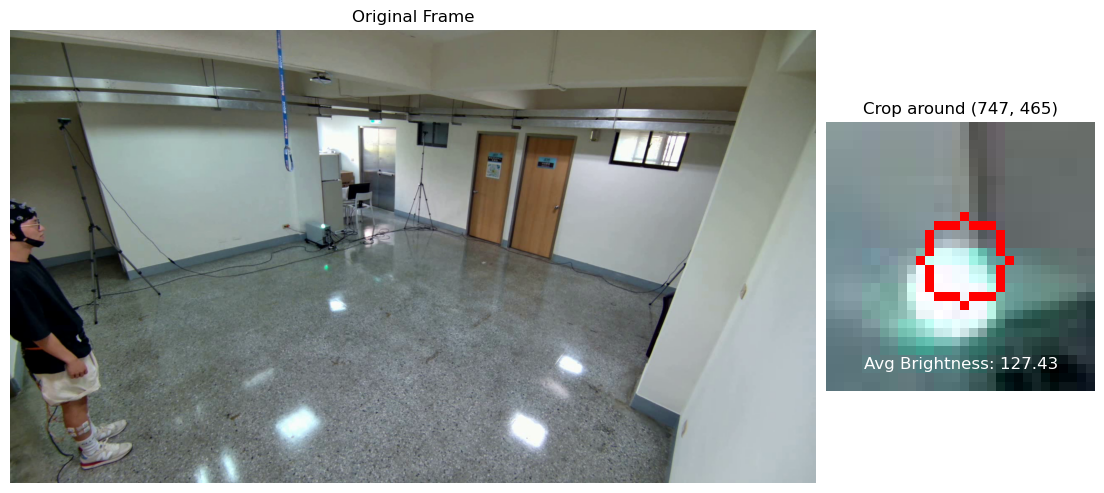

In [16]:
cap = cv2.VideoCapture(video_path)
frame_number = 578
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

lamp_x, lamp_y = 747, 465
half_size = 15
x_start = max(0, lamp_x - half_size)
x_end = min(frame.shape[1], lamp_x + half_size)
y_start = max(0, lamp_y - half_size)
y_end = min(frame.shape[0], lamp_y + half_size)
cropped_frame = frame[y_start:y_end, x_start:x_end]
cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
cropped_frame_gray = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)
avg_brightness = np.mean(cropped_frame_gray)
THRESHOLD = avg_brightness
cropped_lamp_x = lamp_x - x_start
cropped_lamp_y = lamp_y - y_start
cv2.circle(cropped_frame_rgb, (cropped_lamp_x, cropped_lamp_y), radius=5, color=(255, 0, 0), thickness=1)


fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

axs[0].imshow(frame_rgb)
axs[0].set_title('Original Frame')
axs[0].axis('off')
axs[1].imshow(cropped_frame_rgb)
axs[1].set_title(f'Crop around ({lamp_x}, {lamp_y})')
axs[1].axis('off')

axs[1].text(0.5, 0.1, f'Avg Brightness: {avg_brightness:.2f}', color='white',
            fontsize=12, ha='center', va='center', transform=axs[1].transAxes)
plt.subplots_adjust(wspace=0.02)
plt.show()

# the time of start blinking

In [12]:
brightness_values = []
red_values = []
green_values = []
frame_number = 0
max_offset = 30
initial_lamp_x = lamp_x
initial_lamp_y = lamp_y
enable_movement = False
enable_imageShow = True
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        if frame is None:
            print(f"End of video at frame {frame_number}")
        else:
            print(f"Error reading the frame at frame {frame_number}")
        break
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    y_start = max(0, lamp_y - half_size)
    y_end = min(frame.shape[0], lamp_y + half_size)
    x_start = max(0, lamp_x - half_size)
    x_end = min(frame.shape[1], lamp_x + half_size)
    brightness_frame = gray_frame[y_start:y_end, x_start:x_end]

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(brightness_frame)
    if max_val > THRESHOLD and enable_movement:
        new_lamp_x = x_start + max_loc[0]
        new_lamp_y = y_start + max_loc[1]

        if abs(new_lamp_x - initial_lamp_x) > max_offset or abs(new_lamp_y - initial_lamp_y) > max_offset:
            print(f"Error: Lamp moved too far at frame {frame_number}")
            break
        else:
            lamp_x = new_lamp_x
            lamp_y = new_lamp_y
            # print(f"Lamp moved to ({lamp_x}, {lamp_y}) at frame {frame_number}")
        
    avg_brightness = np.mean(brightness_frame)
    brightness_values.append(avg_brightness)

    red_channel = frame[y_start:y_end, x_start:x_end, 2]
    green_channel = frame[y_start:y_end, x_start:x_end, 1]
    avg_red = np.mean(red_channel)
    avg_green = np.mean(green_channel)
    red_values.append(avg_red)
    green_values.append(avg_green)

    cropped_frame = frame[y_start:y_end, x_start:x_end]
    cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
    cropped_lamp_x = max_loc[0]
    cropped_lamp_y = max_loc[1]
    cv2.circle(cropped_frame_rgb, (cropped_lamp_x, cropped_lamp_y), 5, (255, 0, 0), 2)
    if enable_imageShow:
        cv2.imshow("Cropped Frame with Lamp Detected", cropped_frame_rgb)

        # 檢查是否按下 'q' 鍵以退出
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    frame_number += 1

cap.release()
cv2.destroyAllWindows()

End of video at frame 979


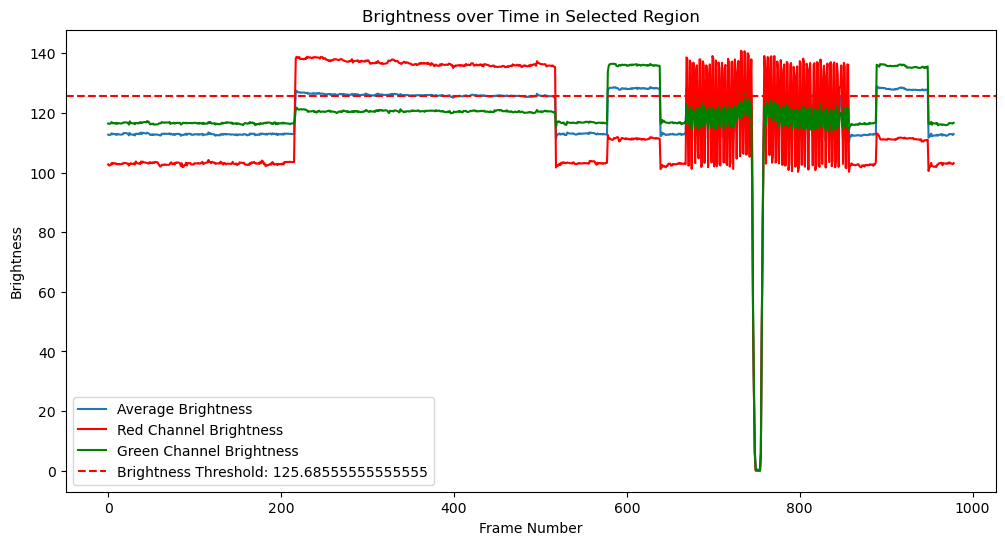

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(brightness_values, label='Average Brightness')
plt.plot(red_values, label='Red Channel Brightness', color='red')
plt.plot(green_values, label='Green Channel Brightness', color='green')
plt.axhline(y=THRESHOLD, color='r', linestyle='--', label=f'Brightness Threshold: {THRESHOLD}')
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.title('Brightness over Time in Selected Region')
plt.legend()
plt.show()

1. find out plateau (plateau_threshold might should be dynamic)
2. trace back the nearest biggest slope

Highest plateau starts at frame 579 with value 136.2696666666667
Maximum slope change near highest plateau at frame 577


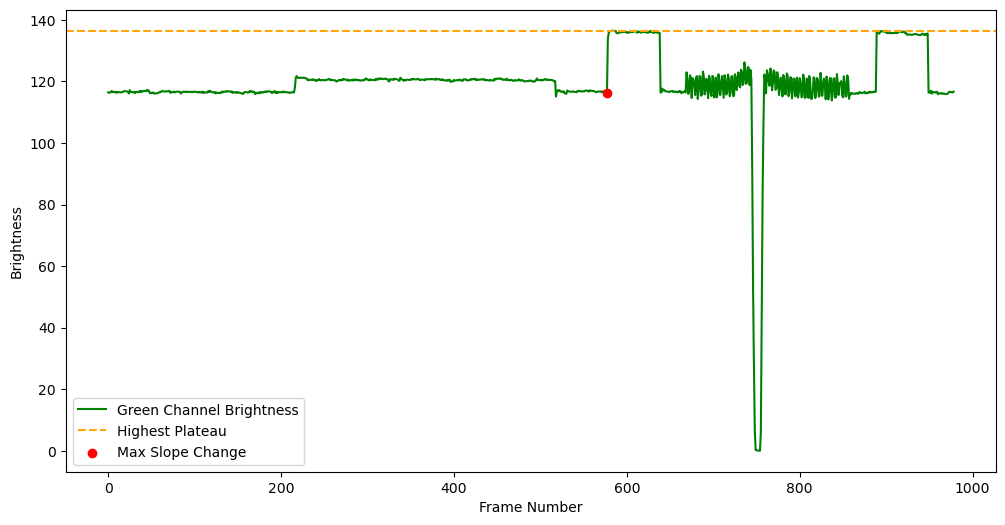

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plateau_threshold = 5
slope_threshold = 5

window_size = 10
smoothed_green = np.convolve(green_values, np.ones(window_size)/window_size, mode='valid')

plateau_mask = np.abs(np.diff(smoothed_green)) < plateau_threshold
plateau_regions = np.where(plateau_mask)[0] + 1

if len(plateau_regions) > 0:
    highest_plateau_idx = np.argmax(smoothed_green[plateau_regions])
    highest_plateau_start = plateau_regions[highest_plateau_idx]
    highest_plateau_value = smoothed_green[highest_plateau_start]
    print(f"Highest plateau starts at frame {highest_plateau_start} with value {highest_plateau_value}")
else:
    print("No plateau found")

green_slope = np.diff(green_values)

slope_region_start = max(0, highest_plateau_start - window_size)
slope_region_end = min(len(green_slope), highest_plateau_start + window_size)

max_slope_idx = np.argmax(np.abs(green_slope[slope_region_start:slope_region_end]))
max_slope_frame = slope_region_start + max_slope_idx

print(f"Maximum slope change near highest plateau at frame {max_slope_frame}")

plt.figure(figsize=(12, 6))
plt.plot(green_values, color='green', label='Green Channel Brightness')
plt.axhline(y=highest_plateau_value, color='orange', linestyle='--', label='Highest Plateau')
plt.scatter(max_slope_frame, green_values[max_slope_frame], color='red', label='Max Slope Change', zorder=5)
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.legend()
plt.show()



In [ ]:
green_start_time = max_slope_frame+1

# Check the blinking freq
this camera has Afterimage

freq of blinking: 0.0 Hz


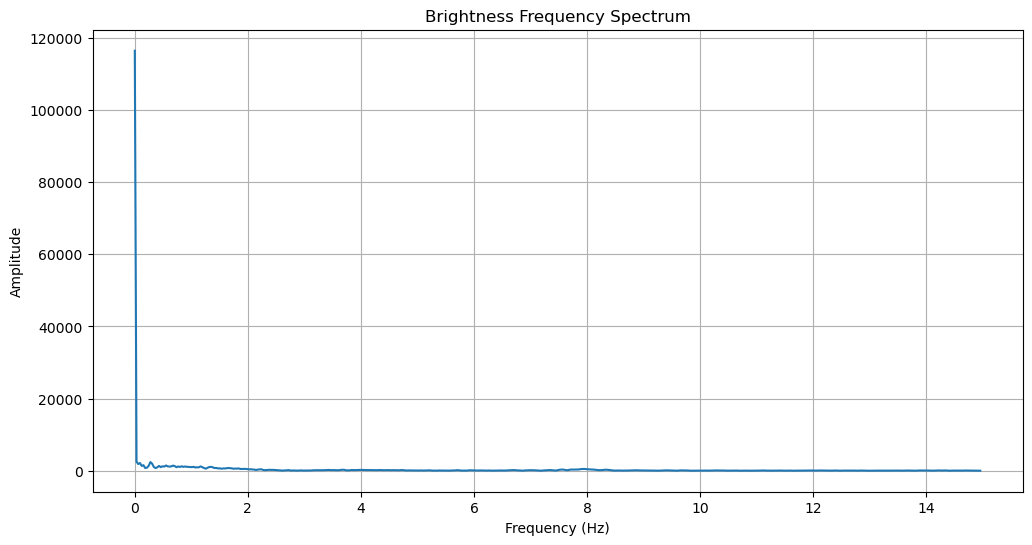

In [17]:
# Theoretically should blink in 16Hz
import numpy as np
from scipy.fft import fft, fftfreq

fps = 30.0
n = len(brightness_values)

brightness_fft = fft(brightness_values)
brightness_freq = fftfreq(n, 1/fps)

positive_freqs = brightness_freq[:n//2]
positive_fft = np.abs(brightness_fft[:n//2])

peak_freq = positive_freqs[np.argmax(positive_fft)]
print(f"freq of blinking: {peak_freq} Hz")

plt.figure(figsize=(12, 6))
plt.plot(positive_freqs, positive_fft)
plt.title('Brightness Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()
